In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
import McExperiment
from McExperiment import *
import importlib
importlib.reload(McExperiment)

<module 'McExperiment' from 'd:\\OneDriveLenovoD\\OneDrive\\A_Fall23\\FIN535\\HW2023\\FIN535-Final-23F\\Dec20\\FIN535-Final-23F\\McExperiment.py'>

In [3]:
data = pd.read_csv('data.csv')
data['month'] = data['month'].apply(lambda x: datetime.strptime(x, '%Y-%m')) #assume each date per month is the last day
data.set_index(['month'],inplace=True)

In [4]:
# read in optimal allocation from excel 
def read_car_rst(n_strat=4):
    # return a table, row = objective, col = optimal allocation, and some critical stats
    ratios = []
    objs = []
    for i in range(n_strat): # for each objective, which corresponds to each sheet
        objs += [list(pd.read_excel('final sheet.xlsx', sheet_name=i).iloc[[11,13,15,17,19],8].values.astype('f'))]
        ratio = list(pd.read_excel('final sheet.xlsx', sheet_name=i).iloc[2,7:12].values.astype('f'))
        ratio[4] *= -1
        ratios += [ratio]
    opt_ratios = pd.DataFrame(ratios, index = ['max uti','max sharpe','max sortino','min mdd'], 
                  columns=['x1','x2','x3','x4','x5'])
    opt_objs = pd.DataFrame(objs, index = ['max uti','max sharpe','max sortino','min mdd'],\
                        columns = ['sharpe','mdd','uti','CE','sortino'])
    return pd.concat([opt_ratios, opt_objs],axis = 1)

n_strat=4
opt_excel_soln = read_car_rst(n_strat)
opt_excel_soln

,x1,x2,x3,x4,x5,sharpe,mdd,uti,CE,sortino
max uti,0.181262,1.024393,0.750000,0.75,-0.205655,1.097224,0.250001,0.006363,12.076599,1.583711
max sharpe,0.490185,0.509815,0.342315,0.75,-0.000000,1.552223,0.250000,0.005783,12.069595,2.142872
max sortino,0.484227,0.515773,0.356543,0.75,-0.000000,1.551894,0.250000,0.005807,12.069884,2.143256
min mdd,0.463338,0.536662,0.280175,0.75,-0.000000,1.510296,0.196292,0.005592,12.067296,2.096605


In [5]:
# Read ratios from grid search 
with open('storage cache/df_results.pkl', 'rb') as file:
    grid_ratios = pickle.load(file)

### Add bench and initilize + Run results

In [6]:
bench_ratio = pd.DataFrame(np.array([[0.6,0.4,0,0,0], [0.7,0.3,0,0,0], [0.5,0.5,0,0,0]]),\
    columns = ['x1','x2','x3','x4','x5'], index = ['bench6/4','bench7/3','bench5/5'])

ratios = pd.concat([bench_ratio,opt_excel_soln.iloc[np.r_[0,2:4],:5],\
    grid_ratios.iloc[np.r_[0,2:5],:]], axis = 0)

In [7]:
# Only keep the max sortino (drop max sharpe)
ratios.index

Index(['bench6/4', 'bench7/3', 'bench5/5', 'max uti', 'max sortino', 'min mdd',
       'uti', 'sortino', 'mdd', 'prob'],
      dtype='object')

In [8]:
car_rst = dict()
car_rst['ratios'] = ratios
car_rst['Simu_table'] = [] # simulated results before taking the avg
car_rst['Cap_table'] = [] # for the financial diamond construction
car_rst['Summary_table'] = [] # after taking the avg of simulated results, then compute some critical stats


In [9]:
SAVE = 40000
CAP = 50000
g = 0.11
MC = 500
path_length = 120 # 10 year
tax_rate = 0.25


for i in tqdm(range(len(ratios))):
    ratio = (ratios.iloc[i,:]).to_list()
    # Get the analysis for end of 5Y/7Y/9Y 
    Simu_table, Simu_cap_table = Experiments_car(MC,path_length,data,CAP,SAVE,g,ratio,years=[60,84,120],tax=tax_rate)
    Summary_table, cap_table = GetSummary(Simu_table, Simu_cap_table, path_length)
    Summary_table = Summary_table.fillna(0)
    car_rst['Simu_table'].append(Simu_table)
    car_rst['Cap_table'].append(cap_table)
    car_rst['Summary_table'].append(Summary_table)

100%|██████████| 10/10 [01:36<00:00,  9.66s/it]


In [19]:
car_rst['Summary_table'][0].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,186114.71,36149.85,186114.71,0.00,1.10,1.50,0.19,0.03,0.01,-386866.33,-387113.66
7Y,299109.47,47117.39,299109.47,0.00,1.08,1.43,0.22,0.41,0.40,-292198.74,-303669.40
10Y,580000.11,91655.45,457702.64,0.79,1.15,1.51,0.23,1.04,1.02,-101612.08,-126004.61


In [20]:
car_rst['Summary_table'][3].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,233419.45,51193.96,233419.45,0.00,1.16,1.68,0.19,0.54,0.54,-364310.63,-373318.24
7Y,399360.32,83240.76,376674.51,0.14,1.15,1.69,0.20,1.27,1.27,-226080.93,-239342.96
10Y,890263.09,183096.75,0.00,1.00,1.19,1.76,0.21,2.31,2.31,84219.78,78362.34


In [21]:
car_rst['Summary_table'][4].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,216967.27,50721.95,216967.27,0.00,1.67,2.21,0.13,0.48,0.48,-380507.83,-380507.83
7Y,360636.75,74326.39,358671.44,0.01,1.58,2.13,0.15,0.95,0.95,-290528.26,-290528.26
10Y,799898.66,163825.24,487837.25,0.99,1.68,2.32,0.15,1.99,1.96,21358.28,13622.66


In [22]:
car_rst['Summary_table'][5].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,217180.33,52003.30,217180.33,0.00,1.63,2.16,0.12,0.58,0.57,-380228.19,-381510.69
7Y,356331.29,78017.88,352737.65,0.02,1.53,2.07,0.14,1.02,1.00,-267297.57,-278786.63
10Y,779689.42,158889.18,474764.72,1.00,1.62,2.25,0.14,1.83,1.83,27787.95,11352.85


In [11]:
car_rst['Summary_table'][6].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,243498.24,49795.64,243498.24,0.00,1.42,1.92,0.18,-0.01,-0.01,148978.02,146406.41
7Y,417825.65,73864.15,401266.03,0.11,1.37,1.87,0.21,-0.01,-0.01,251664.29,251664.29
10Y,991039.84,196263.67,0.00,1.00,1.48,2.06,0.22,-0.01,-0.01,628751.19,618976.89


In [10]:
with open('storage cache/car_rst.pkl', 'wb') as file:
    pickle.dump(car_rst, file)

### Save the results: Plots and Tables

In [3]:
with open('storage cache/car_rst.pkl', 'rb') as file:
        car_rst = pickle.load(file)

In [12]:
# Get stat table:
ptf_name = ['bench6/4', 'bench7/3', 'bench5/5', 'max uti', 'max sortino', 'min mdd',\
    'mc max uti', 'mc max sortino', 'mc min dd','mc max prob']

df_full = pd.concat(car_rst['Summary_table'])

In [13]:
df_5Y = df_full.loc[df_full.index == '5Y']
indexstr = [sub + ' 5Y' for sub in ptf_name] 
df_5Y.index = indexstr
df_5Y.to_csv('storage cache/stat_car_5Y.csv')

In [14]:
df_7Y = df_full.loc[df_full.index == '7Y']
indexstr = [sub + ' 7Y' for sub in ptf_name] 
df_7Y.index = indexstr
df_7Y.to_csv('storage cache/stat_car_7Y.csv')

In [15]:
df_10Y = df_full.loc[df_full.index == '10Y']
indexstr = [sub + ' 10Y' for sub in ptf_name] 
df_10Y.index = indexstr
df_10Y.to_csv('storage cache/stat_car_10Y.csv')

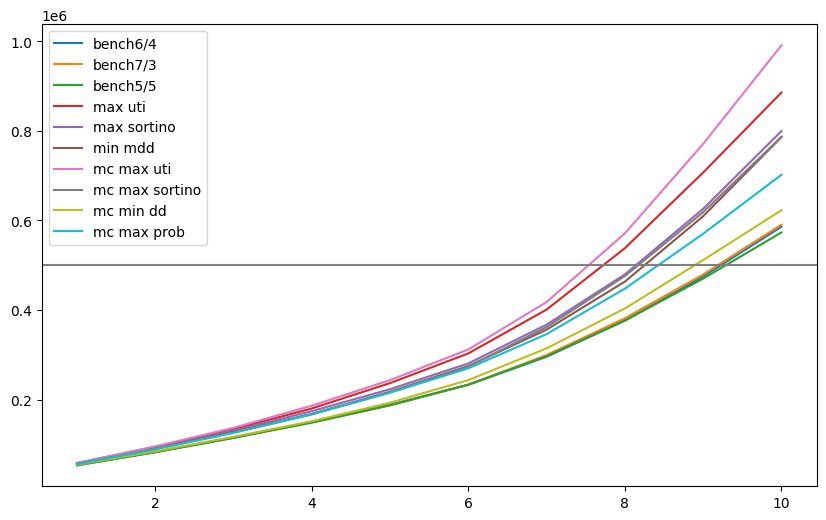

In [17]:
# Capital plot
df_cap = pd.concat(car_rst['Cap_table'],axis = 1)
df_cap.columns = ptf_name

plt.figure(figsize=(10, 6))
plt.plot(df_cap)
plt.axhline(y=500000, color='grey', linestyle='-')
plt.legend(ptf_name)
# plt.savefig('figures/car_capitalplot_all.png',bbox_inches='tight')
plt.show()


## Financial Diamond

In [34]:
def get_loc(year_pts,cap_pts):
    # points coordinates follows the order of left up right down left(the last one is left is just to connect the points to draw a full diamond)
    x_coor = [year_pts[0],year_pts[1],year_pts[2],year_pts[1],year_pts[0]]
    y_coor = [cap_pts[1],cap_pts[2],cap_pts[1],cap_pts[0],cap_pts[1]]
    return x_coor, y_coor

year_pts = [4,5,6] # hard-coded for now, TODO
cap_pts_lst = [[car_rst['Cap_table'][i].iloc[3,0],car_rst['Cap_table'][i].iloc[4,0], car_rst['Cap_table'][i].iloc[5,0]] for i in range(3)] #if my interpretation of the diamond is correct

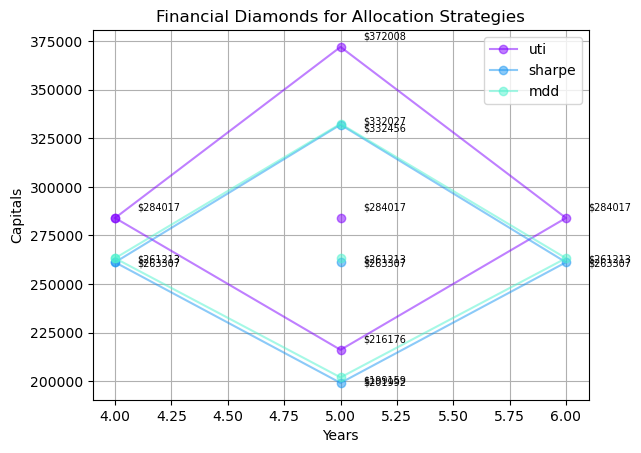

In [36]:
color = iter(cm.rainbow(np.linspace(0, 1, 6)))
labels = ['uti','sharpe','mdd']
fig, ax = plt.subplots()
for i in range(len(cap_pts_lst)):
    c = next(color)
    x_coor, y_coor = get_loc(year_pts,cap_pts_lst[i])
    ax.plot(x_coor, y_coor, '-o',alpha = 0.5, label=labels[i],c=c)
    ax.plot(x_coor[1], y_coor[0], '-o',alpha = 0.5,c=c)
    for j in range(len(x_coor)-1):
        # TODO: the location of the annotation will need to be changed so that they don't overlap
        ax.annotate(f'${round(y_coor[j])}', (x_coor[j]+0.1, y_coor[j]-4000*(i-1)),fontsize=7)
    ax.annotate(f'${round(y_coor[0])}', (x_coor[1]+0.1, y_coor[0]-4000*(i-1)),fontsize=7)
ax.legend()
ax.set_title('Financial Diamonds for Allocation Strategies')
ax.set_xlabel('Years')
ax.set_ylabel('Capitals')
ax.grid()